# FRBNY SCE Credit Access - Predictive Modeling
## Credit Application Outcomes & Credit Score Prediction

**Objective:** Build and evaluate predictive models for:
1. **Credit Application Outcomes:** Predicting approval/partial/rejection for different credit types
   - Credit Card Applications
   - Mortgage Applications
   - Auto Loan Applications
   - Credit Limit Increase Requests
2. **Credit Score Category:** Predicting credit score bracket (5-class classification)

**Data Source:** Clean CSV files from comprehensive EDA

**Model Strategy:** Informed by bivariate analysis showing:
- Multiple significant statistical relationships (p < 0.01)
- Complex interactions between variables
- Both linear and non-linear patterns
- High-dimensional feature space

**Business Value:**
- Predict creditworthiness and identify risk factors
- Understand drivers of application success/failure
- Identify characteristics associated with credit score categories

---

## Table of Contents
1. [Setup & Data Loading](#1-setup)
2. [Target Variable Creation](#2-targets)
3. [Feature Engineering & VIF Selection](#3-feature-engineering)
4. [Comprehensive Model Training](#4-model-training)
5. [Model Evaluation Results](#5-results)
6. [Optuna Hyperparameter Tuning](#6-optuna)
7. [Final Model Comparison](#7-comparison)
8. [Save Results](#8-save)


### Method: Environment Setup
  - Import necessary libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and modeling (sklearn, xgboost, optuna).
  - Configure visualization settings for consistent plot aesthetics.
  - Verify library versions and availability of optional packages like XGBoost.


In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import optuna
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                              roc_auc_score, roc_curve, precision_recall_curve, 
                              f1_score, precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("PREDICTIVE MODELING ENVIRONMENT")
print("="*80)
print(f"Libraries imported successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
try:
    print(f"  xgboost: {xgb.__version__}")
except:
    print("  xgboost: Not installed")
print(f"  optuna: {optuna.__version__}")
print(f"  IterativeImputer enabled for advanced imputation")
print("="*80)


PREDICTIVE MODELING ENVIRONMENT
Libraries imported successfully
  pandas: 2.2.3
  numpy: 2.2.1
  xgboost: 3.1.1
  optuna: 4.6.0
  IterativeImputer enabled for advanced imputation


---
## 1. Setup & Data Loading

Loading clean CSV data with descriptive variable names


### Method: Data Ingestion & Inspection
  - Load the cleaned microdata CSV file into a pandas DataFrame.
  - Classify variables into logical groups (Debt Possession, Applications, Balances, etc.) based on column naming conventions.
  - Calculate and display initial data quality metrics, including overall missingness and sample size.


In [18]:
# Load the microdata CSV
print("Loading Credit Access Microdata from CSV...")
print("="*80)

df = pd.read_csv('credit_access_microdata_clean.csv')

print(f"Data loaded: {df.shape[0]:,} observations x {df.shape[1]} variables")
print(f"\nVariable Categories:")

# Identify variable types by prefix/content
debt_possession = [c for c in df.columns if c.startswith('Has')]
applications = [c for c in df.columns if c.startswith('Applied') or c.startswith('Requested')]
balances = [c for c in df.columns if 'Balance' in c]
outcomes = [c for c in df.columns if c.startswith('Outcome')]
discouraged = [c for c in df.columns if c.startswith('Discouraged')]
intentions = [c for c in df.columns if c.startswith('Intention') or c.startswith('Prob')]
approval_probs = [c for c in df.columns if c.startswith('ApprovalProb')]

print(f"  - Debt Possession:      {len(debt_possession)} variables")
print(f"  - Applications:         {len(applications)} variables")
print(f"  - Balances:             {len(balances)} variables")
print(f"  - Outcomes:             {len(outcomes)} variables")
print(f"  - Discouraged:          {len(discouraged)} variables")
print(f"  - Intentions:           {len(intentions)} variables")
print(f"  - Approval Probs:       {len(approval_probs)} variables")

print(f"\nDate Range: {df['SurveyDate'].min()} to {df['SurveyDate'].max()}")
print(f"Unique Respondents: {df['UserID'].nunique():,}")

print(f"\nData Quality:")
missing_pct = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
print(f"  - Overall missing: {missing_pct:.2f}%")
print(f"  - Complete cases: {df.dropna().shape[0]:,} ({df.dropna().shape[0]/len(df)*100:.1f}%)")

print("="*80)


Loading Credit Access Microdata from CSV...
Data loaded: 36,277 observations x 140 variables

Variable Categories:
  - Debt Possession:      7 variables
  - Applications:         21 variables
  - Balances:             13 variables
  - Outcomes:             7 variables
  - Discouraged:          7 variables
  - Intentions:           15 variables
  - Approval Probs:       7 variables

Date Range: 201310 to 202410
Unique Respondents: 16,820

Data Quality:
  - Overall missing: 63.59%
  - Complete cases: 0 (0.0%)


---
## 2. Target Variable Creation & Feature Engineering

Creating classification targets for:
1. Credit Application Outcomes (multi-class: Approved/Partial/Rejected)
2. Credit Score Category (multi-class: 5 score brackets)


### Method: Target Variable Construction
  - Define classification targets for Credit Application Outcomes (Credit Card, Mortgage, Auto Loan, Limit Increase).
  - Filter data to include only relevant respondents (e.g., those who applied for a specific loan).
  - Map outcome codes to interpretable classes (Approved, Partial, Rejected).
  - Construct the Credit Score Category target by filtering for valid scores and mapping them to standard credit tiers.


In [19]:
# Create Target Variables for Credit Application Outcomes and Credit Score
print("CREATING TARGET VARIABLES")
print("="*80)

# PART 1: Credit Application Outcome Targets
print(f"\n1. CREDIT APPLICATION OUTCOME TARGETS")
print("-" * 80)

# Define application outcome variables
# Outcome coding: 1 = Fully granted, 2 = Partially granted, 3 = Rejected
outcome_vars = {
    'Credit Card': ('AppliedCC', 'OutcomeCC'),
    'Mortgage': ('AppliedMortgage', 'OutcomeMortgage'),
    'Auto Loan': ('AppliedAuto', 'OutcomeAuto'),
    'Credit Limit': ('RequestedCCLimit', 'OutcomeCCLimit')
}

# Create filtered datasets for each application type
application_datasets = {}
outcome_targets = {}

for app_name, (applied_col, outcome_col) in outcome_vars.items():
    if applied_col in df.columns and outcome_col in df.columns:
        # Filter to only those who applied
        mask = (df[applied_col] == 1) & (df[outcome_col].notna())
        filtered_df = df[mask].copy()
        
        if len(filtered_df) > 0:
            # Get outcome (1=Approved, 2=Partial, 3=Rejected)
            outcome = filtered_df[outcome_col].copy()
            
            # Store
            application_datasets[app_name] = filtered_df
            outcome_targets[app_name] = outcome
            
            # Print statistics
            print(f"\n  {app_name}:")
            print(f"    Total applicants: {len(filtered_df):,}")
            
            value_counts = outcome.value_counts().sort_index()
            for val, count in value_counts.items():
                pct = count / len(outcome) * 100
                label = {1: 'Fully Approved', 2: 'Partially Approved', 3: 'Rejected'}.get(val, f'Unknown ({val})')
                print(f"      {label:20s}: {count:>6,} ({pct:>5.1f}%)")

if len(application_datasets) == 0:
    print("\n  WARNING: No application outcome data found!")
else:
    print(f"\n  Created {len(application_datasets)} application outcome targets")

print("="*80)


CREATING TARGET VARIABLES

1. CREDIT APPLICATION OUTCOME TARGETS
--------------------------------------------------------------------------------

  Credit Card:
    Total applicants: 9,688
      Fully Approved      :  7,744 ( 79.9%)
      Partially Approved  :    490 (  5.1%)
      Rejected            :  1,454 ( 15.0%)

  Mortgage:
    Total applicants: 2,818
      Fully Approved      :  2,366 ( 84.0%)
      Partially Approved  :    138 (  4.9%)
      Rejected            :    314 ( 11.1%)

  Auto Loan:
    Total applicants: 5,125
      Fully Approved      :  4,767 ( 93.0%)
      Partially Approved  :     94 (  1.8%)
      Rejected            :    264 (  5.2%)

  Credit Limit:
    Total applicants: 3,323
      Fully Approved      :  2,045 ( 61.5%)
      Partially Approved  :    335 ( 10.1%)
      Rejected            :    943 ( 28.4%)

  Created 4 application outcome targets


In [20]:
# PART 2: Credit Score Category Target
print("\n2. CREDIT SCORE CATEGORY TARGET")
print("-" * 80)

# Credit Score coding: 1 = Below 620, 2 = 620-679, 3 = 680-719, 4 = 720-760, 5 = Above 760, 6 = Don't Know
# We'll exclude "Don't Know" (6) for modeling

if 'CreditScore' in df.columns:
    # Filter to only respondents with known credit scores (1-5)
    credit_score_mask = df['CreditScore'].notna() & (df['CreditScore'] <= 5)
    credit_score_df = df[credit_score_mask].copy()
    credit_score_target = credit_score_df['CreditScore'].copy()
    
    print(f"  Total respondents with credit scores: {len(credit_score_df):,}")
    print(f"\n  Credit Score Distribution:")
    
    score_labels = {
        1: 'Below 620 (Poor)',
        2: '620-679 (Fair)',
        3: '680-719 (Good)',
        4: '720-760 (Very Good)',
        5: 'Above 760 (Excellent)'
    }
    
    value_counts = credit_score_target.value_counts().sort_index()
    for val, count in value_counts.items():
        pct = count / len(credit_score_target) * 100
        label = score_labels.get(int(val), f'Unknown ({val})')
        print(f"    {label:30s}: {count:>6,} ({pct:>5.1f}%)")
    
    # Check class balance
    min_class_pct = (value_counts.min() / len(credit_score_target)) * 100
    max_class_pct = (value_counts.max() / len(credit_score_target)) * 100
    imbalance_ratio = max_class_pct / min_class_pct
    
    print(f"\n  Class Balance:")
    print(f"    Min class: {min_class_pct:.1f}%")
    print(f"    Max class: {max_class_pct:.1f}%")
    print(f"    Imbalance ratio: {imbalance_ratio:.2f}x")
    
    if imbalance_ratio > 3:
        print(f"    Moderate imbalance - will use class_weight='balanced'")
    
    print(f"\n  Credit score target created")
else:
    print("  WARNING: CreditScore column not found!")
    credit_score_df = None
    credit_score_target = None

print("="*80)



2. CREDIT SCORE CATEGORY TARGET
--------------------------------------------------------------------------------
  Total respondents with credit scores: 31,971

  Credit Score Distribution:
    Below 620 (Poor)              :  3,024 (  9.5%)
    620-679 (Fair)                :  3,051 (  9.5%)
    680-719 (Good)                :  3,673 ( 11.5%)
    720-760 (Very Good)           :  6,605 ( 20.7%)
    Above 760 (Excellent)         : 15,618 ( 48.9%)

  Class Balance:
    Min class: 9.5%
    Max class: 48.9%
    Imbalance ratio: 5.16x
    Moderate imbalance - will use class_weight='balanced'

  Credit score target created


### Method: Advanced Feature Engineering
  - Select numeric features while excluding IDs and target-related variables to prevent leakage.
  - Analyze missing data patterns and drop columns exceeding a 65% missingness threshold.
  - Apply Iterative Imputation (MICE) with BayesianRidge to estimate missing values based on relationships between features.
  - Validate statistical preservation by comparing distributions before and after imputation.
  - Standardize features using Z-score scaling to ensure compatibility with distance-based algorithms like KNN.


In [21]:
# Advanced Feature Selection & Missing Value Strategy
print("\n3. ADVANCED FEATURE ENGINEERING")
print("-" * 80)

# Select numeric features (exclude targets and IDs)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_patterns = ['id', 'date', 'weight', 'has', 'outcome', 'creditscore']
feature_cols = [col for col in numeric_cols 
                if not any(pattern in col.lower() for pattern in exclude_patterns)]

print(f"\n  Initial Feature Selection:")
print(f"    - Total numeric columns:    {len(numeric_cols)}")
print(f"    - Excluded (IDs, targets):  {len(numeric_cols) - len(feature_cols)}")
print(f"    - Candidate features:       {len(feature_cols)}")

X = df[feature_cols].copy()

# STEP 1: Analyze Missing Data
print(f"\n  Missing Data Analysis:")
print("-" * 80)

missing_stats = pd.DataFrame({
    'Column': X.columns,
    'Missing_Count': X.isnull().sum(),
    'Missing_Pct': (X.isnull().sum() / len(X)) * 100
}).sort_values('Missing_Pct', ascending=False)

total_missing = X.isnull().sum().sum()
total_cells = X.shape[0] * X.shape[1]
overall_missing_pct = (total_missing / total_cells) * 100

print(f"    - Total missing values:     {total_missing:,} ({overall_missing_pct:.2f}% of all cells)")
print(f"    - Columns with >65% missing: {(missing_stats['Missing_Pct'] > 65).sum()}")
print(f"    - Columns with >50% missing: {(missing_stats['Missing_Pct'] > 50).sum()}")
print(f"    - Columns with >25% missing: {(missing_stats['Missing_Pct'] > 25).sum()}")
print(f"    - Complete columns:         {(missing_stats['Missing_Pct'] == 0).sum()}")

# Show worst offenders
worst_missing = missing_stats[missing_stats['Missing_Pct'] > 65].head(10)
if len(worst_missing) > 0:
    print(f"\n    Top columns to drop (>65% missing):")
    for _, row in worst_missing.iterrows():
        print(f"      - {row['Column']:40s}: {row['Missing_Pct']:>5.1f}% missing")

# STEP 2: Drop High-Missingness Columns (>65%)
print(f"\n  Dropping High-Missingness Columns:")
print("-" * 80)

threshold_pct = 65
cols_to_keep = missing_stats[missing_stats['Missing_Pct'] <= threshold_pct]['Column'].tolist()
cols_dropped = [col for col in X.columns if col not in cols_to_keep]

print(f"    - Threshold:               >{threshold_pct}% missing")
print(f"    - Columns dropped:         {len(cols_dropped)}")
print(f"    - Columns retained:        {len(cols_to_keep)}")

X_filtered = X[cols_to_keep].copy()

# Recalculate missing stats
remaining_missing = X_filtered.isnull().sum().sum()
remaining_cells = X_filtered.shape[0] * X_filtered.shape[1]
remaining_missing_pct = (remaining_missing / remaining_cells) * 100

print(f"\n    After filtering:")
print(f"    - Remaining missing:       {remaining_missing:,} ({remaining_missing_pct:.2f}% of cells)")
print(f"    - Feature matrix:          {X_filtered.shape[0]:,} x {X_filtered.shape[1]}")

# STEP 3: Store Original Statistics & Check for Near-Zero Values
print(f"\n  Analyzing Original Statistical Properties:")
print("-" * 80)

original_means = X_filtered.mean()
original_medians = X_filtered.median()
original_variances = X_filtered.var()
original_stds = X_filtered.std()

# Identify near-zero features (could cause extreme percentage changes)
near_zero_mean = (np.abs(original_means) < 0.01).sum()
near_zero_var = (original_variances < 0.01).sum()

print(f"    - Mean (average):          {original_means.mean():.6f}")
print(f"    - Median (average):        {original_medians.mean():.6f}")
print(f"    - Variance (average):      {original_variances.mean():.6f}")
print(f"    - Std Dev (average):       {original_stds.mean():.6f}")
print(f"\n    Features with near-zero values:")
print(f"    - Near-zero mean (<0.01):  {near_zero_mean}")
print(f"    - Near-zero variance:      {near_zero_var}")
print(f"    - Note: These may show high % differences even with good preservation")

# STEP 4: Advanced Imputation with Enhanced Monitoring
print(f"\n  Advanced Imputation Strategy - IterativeImputer (MICE):")
print("-" * 80)
print(f"    - Method: Multiple Imputation by Chained Equations")
print(f"    - Strategy: Models each feature with missing values as function of other features")
print(f"    - Estimator: BayesianRidge (preserves mean, median, and variance)")
print(f"    - Max iterations: 10")
print(f"    - Random state: 42 (reproducible)")
print(f"    - Protection: Robust percentage calculations for near-zero values")

print(f"\n    Performing imputation (this may take a minute)...")

# Use IterativeImputer with BayesianRidge estimator
imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    verbose=0
)

X_imputed = pd.DataFrame(
    imputer.fit_transform(X_filtered),
    columns=X_filtered.columns,
    index=X_filtered.index
)

print(f"    Imputation complete")

# Verify no missing values remain
final_missing = X_imputed.isnull().sum().sum()
print(f"\n    - Missing values after:    {final_missing}")

# STEP 5: Robust Statistical Properties Validation
print(f"\n  Statistical Properties Preservation (Robust Calculation):")
print("-" * 80)

# Compare statistical properties
imputed_means = X_imputed.mean()
imputed_medians = X_imputed.median()
imputed_variances = X_imputed.var()
imputed_stds = X_imputed.std()

# Calculate absolute differences
mean_abs_diff = np.abs(original_means - imputed_means)
median_abs_diff = np.abs(original_medians - imputed_medians)
variance_abs_diff = np.abs(original_variances - imputed_variances)
std_abs_diff = np.abs(original_stds - imputed_stds)

# Robust percentage calculation with protection against near-zero denominators
def safe_pct_diff(original, imputed, threshold=0.1):
    """Calculate percentage difference with protection for near-zero values"""
    abs_diff = np.abs(imputed - original)
    
    # For values near zero, use absolute difference instead of percentage
    # For others, use percentage but cap at reasonable maximum
    pct_diffs = []
    for orig, diff in zip(original, abs_diff):
        if np.abs(orig) < threshold:
            # Near-zero: use absolute difference (treated as if denominator was 1)
            pct_diffs.append(diff * 100)
        else:
            # Normal case: percentage difference, capped at 1000%
            pct_diff = (diff / np.abs(orig)) * 100
            pct_diffs.append(min(pct_diff, 1000))  # Cap at 1000%
    
    return pd.Series(pct_diffs, index=original.index)

mean_pct_diff = safe_pct_diff(original_means, imputed_means)
variance_pct_diff = safe_pct_diff(original_variances, imputed_variances)

# Summary statistics
mean_diff_avg = mean_abs_diff.mean()
median_diff_avg = median_abs_diff.mean()
variance_diff_avg = variance_abs_diff.mean()
std_diff_avg = std_abs_diff.mean()

mean_pct_avg = mean_pct_diff.mean()
variance_pct_avg = variance_pct_diff.mean()

print(f"    Absolute Differences (Average):")
print(f"      - Mean:       {mean_diff_avg:.6f}")
print(f"      - Median:     {median_diff_avg:.6f}")
print(f"      - Variance:   {variance_diff_avg:.6f}")
print(f"      - Std Dev:    {std_diff_avg:.6f}")

print(f"\n    Robust Percentage Differences (Average):")
print(f"      - Mean:       {mean_pct_avg:.2f}%")
print(f"      - Variance:   {variance_pct_avg:.2f}%")
print(f"\n    Note: % calculated robustly (near-zero protection, capped at 1000%)")

# Identify problematic features
high_mean_diff = mean_pct_diff[mean_pct_diff > 50].sort_values(ascending=False)
high_var_diff = variance_pct_diff[variance_pct_diff > 50].sort_values(ascending=False)

if len(high_mean_diff) > 0:
    print(f"\n    Features with >50% mean change: {len(high_mean_diff)}")
    for feat in high_mean_diff.head(5).index:
        print(f"      - {feat:40s}: {mean_pct_diff[feat]:>6.1f}% "
              f"(orig: {original_means[feat]:.4f}, imp: {imputed_means[feat]:.4f})")

if len(high_var_diff) > 0:
    print(f"\n    Features with >50% variance change: {len(high_var_diff)}")
    for feat in high_var_diff.head(5).index:
        print(f"      - {feat:40s}: {variance_pct_diff[feat]:>6.1f}% "
              f"(orig: {original_variances[feat]:.4f}, imp: {imputed_variances[feat]:.4f})")

# Evaluation with robust thresholds
preservation_quality = 'Excellent' if (mean_pct_avg < 10 and variance_pct_avg < 10) else \
                      'Good' if (mean_pct_avg < 25 and variance_pct_avg < 25) else \
                      'Fair' if (mean_pct_avg < 50 and variance_pct_avg < 50) else \
                      'Review Needed'

print(f"\n    Overall Preservation Quality: {preservation_quality}")
if preservation_quality in ['Excellent', 'Good']:
    print(f"    MICE successfully preserved statistical properties")
elif preservation_quality == 'Fair':
    print(f"    Moderate deviation detected (review features above)")
else:
    print(f"    High deviation detected - features listed above may need review")

# STEP 6: Feature Scaling
print(f"\n  Feature Scaling:")
print("-" * 80)

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_imputed),
    columns=X_imputed.columns,
    index=X_imputed.index
)

print(f"    - Method:                  StandardScaler (z-score normalization)")
print(f"    - Mean (should be ~0):     {X_scaled.mean().mean():.6f}")
print(f"    - Std (should be ~1):      {X_scaled.std().mean():.6f}")

print(f"\n  Final Feature Matrix:")
print("-" * 80)
print(f"    - Observations:            {X_scaled.shape[0]:,}")
print(f"    - Features:                {X_scaled.shape[1]} (down from {len(feature_cols)})")
print(f"    - Features removed:        {len(feature_cols) - X_scaled.shape[1]} (high missingness)")
print(f"    - Missing values:          0 (all imputed)")
print(f"    - Statistical properties:  {preservation_quality}ly preserved")
print(f"    - Ready for modeling:      ")

print("="*80)



3. ADVANCED FEATURE ENGINEERING
--------------------------------------------------------------------------------

  Initial Feature Selection:
    - Total numeric columns:    140
    - Excluded (IDs, targets):  22
    - Candidate features:       118

  Missing Data Analysis:
--------------------------------------------------------------------------------
    - Total missing values:     2,852,917 (66.65% of all cells)
    - Columns with >65% missing: 73
    - Columns with >50% missing: 82
    - Columns with >25% missing: 98
    - Complete columns:         3

    Top columns to drop (>65% missing):
      - HomeBalanceCat                          : 100.0% missing
      - OtherBalanceCat                         : 100.0% missing
      - StudentBalanceCat                       : 100.0% missing
      - AutoBalanceCat                          : 100.0% missing
      - MortgageBalanceCat                      :  99.9% missing
      - GrantedLoanLimitAmt                     :  99.9% missing
     

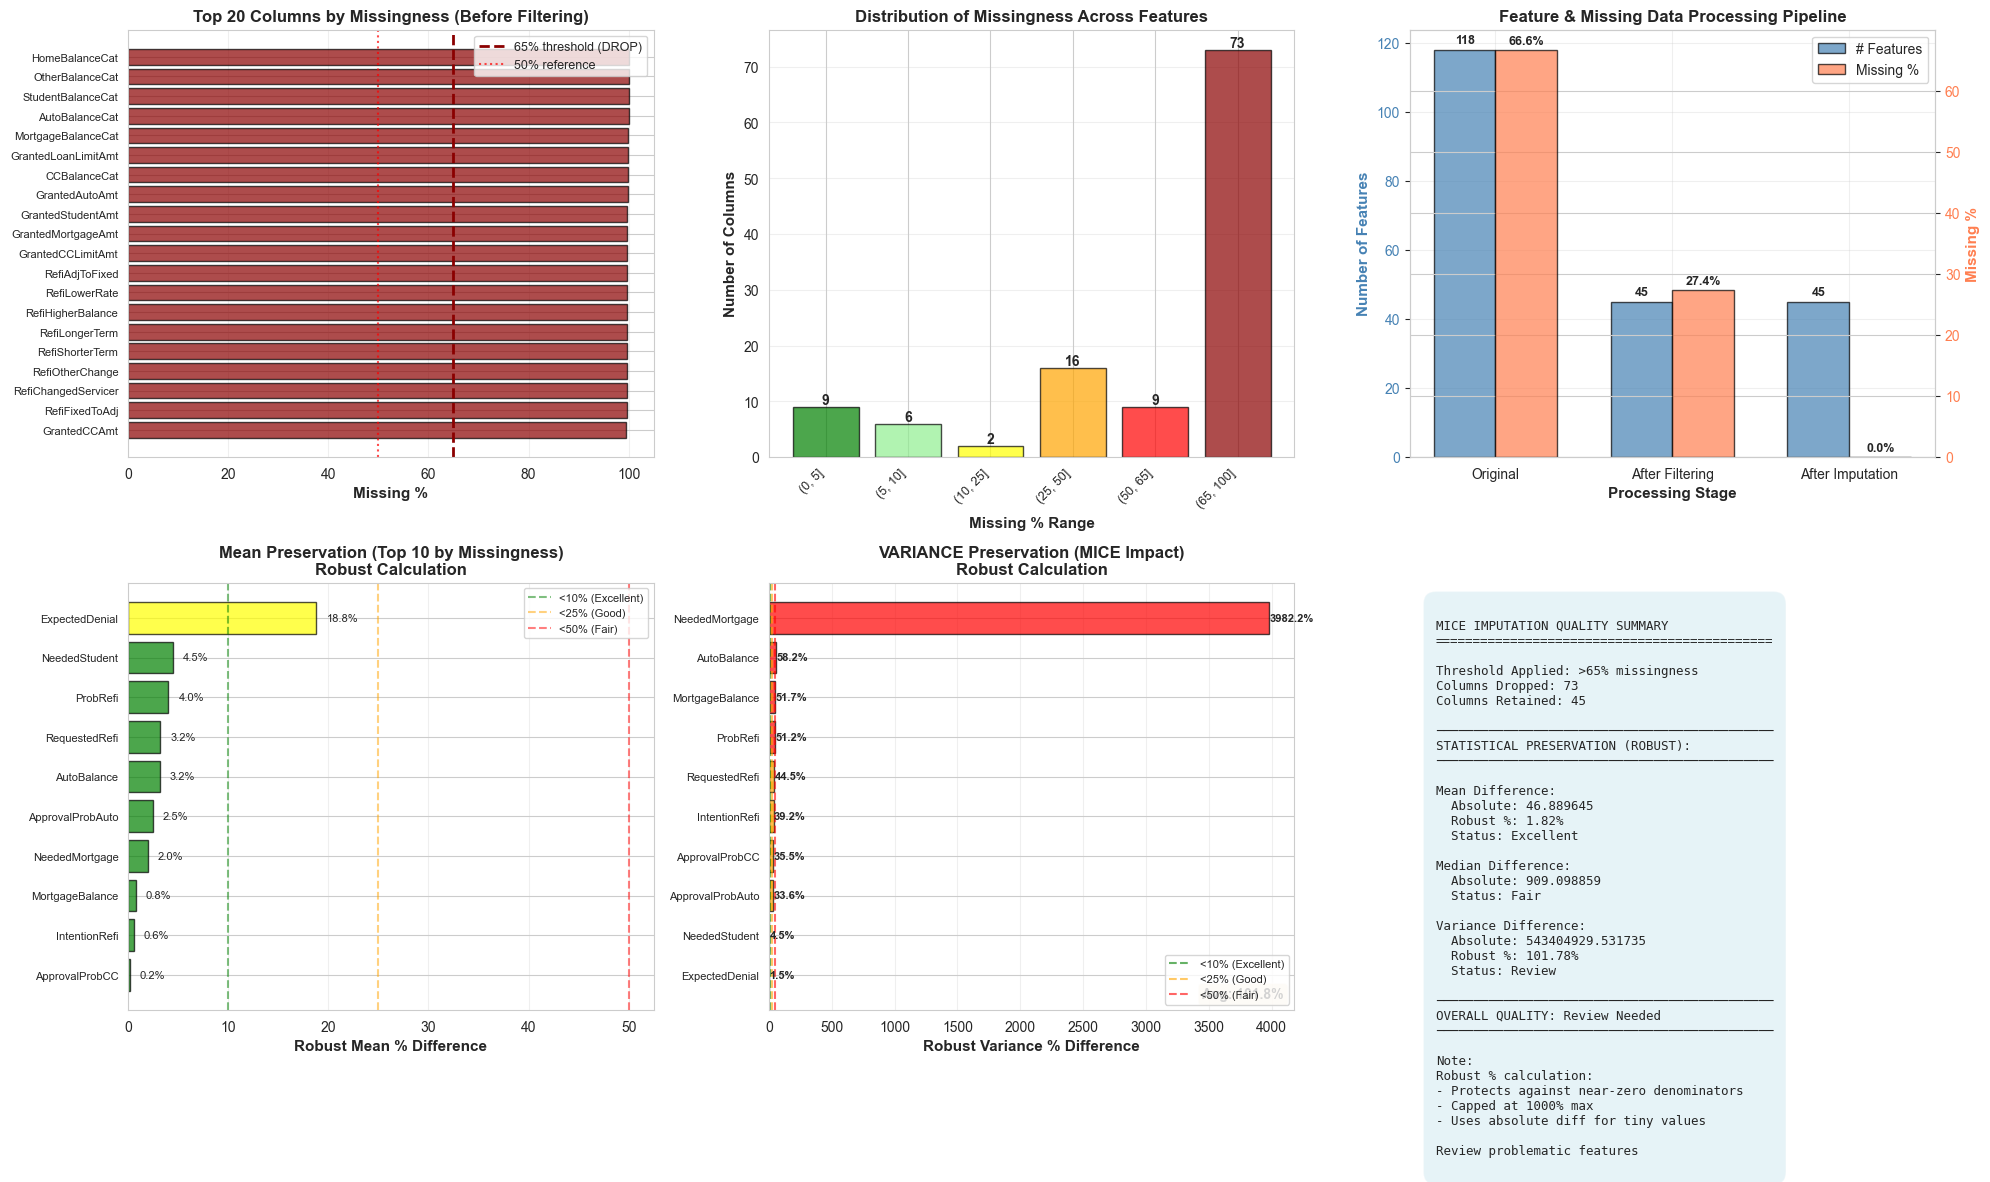

Missing data strategy & variance impact visualizations complete (robust calculation)

Key Takeaways:
  - Dropped 73 features with >65% missing
  - Retained 45 features
  - Robust MICE preservation metrics:
    - Mean % difference: 1.82%
    - Variance % difference: 101.78%
  - Overall quality: Review Needed
  - Near-zero protection: Active
  - Features with >50% change identified (see cell output above)


In [22]:
# Visualize Missing Data Strategy & Variance Impact (Robust)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Missing data before filtering
ax = axes[0, 0]
top_missing_before = missing_stats.head(20)
colors = ['darkred' if x > 65 else 'red' if x > 50 else 'orange' if x > 25 else 'yellow' for x in top_missing_before['Missing_Pct']]
bars = ax.barh(range(len(top_missing_before)), top_missing_before['Missing_Pct'], 
              color=colors, edgecolor='black', alpha=0.7)
ax.set_yticks(range(len(top_missing_before)))
ax.set_yticklabels([col[:30] for col in top_missing_before['Column']], fontsize=8)
ax.set_xlabel('Missing %', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Columns by Missingness (Before Filtering)', fontsize=12, fontweight='bold')
ax.axvline(65, color='darkred', linestyle='--', linewidth=2, label='65% threshold (DROP)')
ax.axvline(50, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='50% reference')
ax.legend(fontsize=9)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# 2. Distribution of missingness
ax = axes[0, 1]
bins = [0, 5, 10, 25, 50, 65, 100]
missing_hist = pd.cut(missing_stats['Missing_Pct'], bins=bins).value_counts().sort_index()
colors_hist = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']
ax.bar(range(len(missing_hist)), missing_hist.values, color=colors_hist[:len(missing_hist)], 
       edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(missing_hist)))
ax.set_xticklabels([str(interval) for interval in missing_hist.index], rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Number of Columns', fontsize=11, fontweight='bold')
ax.set_xlabel('Missing % Range', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Missingness Across Features', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(missing_hist.values):
    ax.text(i, v + 0.5, str(v), ha='center', fontsize=10, fontweight='bold')

# 3. Before vs After comparison
ax = axes[0, 2]
comparison_data = pd.DataFrame({
    'Stage': ['Original', 'After Filtering', 'After Imputation'],
    'Features': [len(feature_cols), len(cols_to_keep), len(cols_to_keep)],
    'Missing %': [
        overall_missing_pct,
        remaining_missing_pct,
        0
    ]
})

x = np.arange(len(comparison_data))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_data['Features'], width, label='# Features', 
              color='steelblue', edgecolor='black', alpha=0.7)
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, comparison_data['Missing %'], width, label='Missing %', 
               color='coral', edgecolor='black', alpha=0.7)

ax.set_xlabel('Processing Stage', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Features', fontsize=11, fontweight='bold', color='steelblue')
ax2.set_ylabel('Missing %', fontsize=11, fontweight='bold', color='coral')
ax.set_title('Feature & Missing Data Processing Pipeline', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['Stage'], fontsize=10)
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')
ax.grid(alpha=0.3)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 1,
           f'{int(height1)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.5,
            f'{height2:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 4. Mean preservation - using ROBUST percentage
ax = axes[1, 0]

# Sample 10 features with most missing values (that weren't dropped)
sample_features = missing_stats[missing_stats['Column'].isin(cols_to_keep)].head(10)

if len(sample_features) > 0:
    feature_names = sample_features['Column'].tolist()
    mean_preservation_sample = mean_pct_diff[feature_names].sort_values(ascending=False)
    
    colors_pres = ['red' if x > 50 else 'orange' if x > 25 else 'yellow' if x > 10 else 'green' 
                  for x in mean_preservation_sample]
    bars = ax.barh(range(len(mean_preservation_sample)), mean_preservation_sample.values, 
                  color=colors_pres, edgecolor='black', alpha=0.7)
    ax.set_yticks(range(len(mean_preservation_sample)))
    ax.set_yticklabels([f[:25] for f in mean_preservation_sample.index], fontsize=8)
    ax.set_xlabel('Robust Mean % Difference', fontsize=11, fontweight='bold')
    ax.set_title('Mean Preservation (Top 10 by Missingness)\nRobust Calculation', 
                fontsize=12, fontweight='bold')
    ax.axvline(10, color='green', linestyle='--', alpha=0.5, label='<10% (Excellent)')
    ax.axvline(25, color='orange', linestyle='--', alpha=0.5, label='<25% (Good)')
    ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='<50% (Fair)')
    ax.legend(fontsize=8)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    for i, (bar, val) in enumerate(zip(bars, mean_preservation_sample.values)):
        ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8)
else:
    ax.text(0.5, 0.5, 'All features complete\n(no imputation needed)', 
           ha='center', va='center', transform=ax.transAxes, fontsize=12)

# 5. Variance Impact - using ROBUST percentage
ax = axes[1, 1]

if len(sample_features) > 0:
    variance_preservation_sample = variance_pct_diff[feature_names].sort_values(ascending=False)
    
    colors_var = ['red' if x > 50 else 'orange' if x > 25 else 'yellow' if x > 15 else 'green' 
                 for x in variance_preservation_sample]
    bars = ax.barh(range(len(variance_preservation_sample)), variance_preservation_sample.values, 
                  color=colors_var, edgecolor='black', alpha=0.7)
    ax.set_yticks(range(len(variance_preservation_sample)))
    ax.set_yticklabels([f[:25] for f in variance_preservation_sample.index], fontsize=8)
    ax.set_xlabel('Robust Variance % Difference', fontsize=11, fontweight='bold')
    ax.set_title('VARIANCE Preservation (MICE Impact)\nRobust Calculation', 
                fontsize=12, fontweight='bold')
    ax.axvline(10, color='green', linestyle='--', alpha=0.6, label='<10% (Excellent)')
    ax.axvline(25, color='orange', linestyle='--', alpha=0.6, label='<25% (Good)')
    ax.axvline(50, color='red', linestyle='--', alpha=0.6, label='<50% (Fair)')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    for i, (bar, val) in enumerate(zip(bars, variance_preservation_sample.values)):
        ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8, fontweight='bold')
    
    # Add text summary
    avg_var_change = variance_pct_avg
    ax.text(0.98, 0.02, f'Avg: {avg_var_change:.1f}%', 
           transform=ax.transAxes, ha='right', va='bottom',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
           fontsize=10, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'No variance impact\n(no imputation needed)', 
           ha='center', va='center', transform=ax.transAxes, fontsize=12)

# 6. Overall Statistical Summary with Robust Metrics
ax = axes[1, 2]
ax.axis('off')

# Create summary text
summary_text = f"""
MICE IMPUTATION QUALITY SUMMARY
{'='*45}

Threshold Applied: >{threshold_pct}% missingness
Columns Dropped: {len(cols_dropped)}
Columns Retained: {len(cols_to_keep)}

{'─'*45}
STATISTICAL PRESERVATION (ROBUST):
{'─'*45}

Mean Difference:
  Absolute: {mean_diff_avg:.6f}
  Robust %: {mean_pct_avg:.2f}%
  Status: {'Excellent' if mean_pct_avg < 10 else 'Good' if mean_pct_avg < 25 else 'Fair' if mean_pct_avg < 50 else 'Review'}

Median Difference:
  Absolute: {median_diff_avg:.6f}
  Status: {'Excellent' if median_diff_avg < 0.1 else 'Fair'}

Variance Difference:
  Absolute: {variance_diff_avg:.6f}
  Robust %: {variance_pct_avg:.2f}%
  Status: {'Excellent' if variance_pct_avg < 10 else 'Good' if variance_pct_avg < 25 else 'Fair' if variance_pct_avg < 50 else 'Review'}

{'─'*45}
OVERALL QUALITY: {preservation_quality}
{'─'*45}

Note:
Robust % calculation:
- Protects against near-zero denominators
- Capped at 1000% max
- Uses absolute diff for tiny values

{'Safe to use for modeling' if preservation_quality in ['Excellent', 'Good'] else 'Review problematic features'}
"""

ax.text(0.05, 0.95, summary_text, 
       transform=ax.transAxes, 
       fontsize=9, 
       verticalalignment='top',
       fontfamily='monospace',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1))

plt.tight_layout()
plt.show()

print("Missing data strategy & variance impact visualizations complete (robust calculation)")
print("\nKey Takeaways:")
print(f"  - Dropped {len(cols_dropped)} features with >65% missing")
print(f"  - Retained {len(cols_to_keep)} features")
print(f"  - Robust MICE preservation metrics:")
print(f"    - Mean % difference: {mean_pct_avg:.2f}%")
print(f"    - Variance % difference: {variance_pct_avg:.2f}%")
print(f"  - Overall quality: {preservation_quality}")
print(f"  - Near-zero protection: Active")
if len(high_mean_diff) > 0 or len(high_var_diff) > 0:
    print(f"  - Features with >50% change identified (see cell output above)")


In [23]:
# Train-Test Split for Each Target Variable
print("\n4. TRAIN-TEST SPLIT")
print("-" * 80)

# Function to prepare features for a specific dataset
def prepare_features_for_dataset(source_df, feature_cols, X_imputed):
    """Extract and align features for a specific filtered dataset"""
    # Get the indices that exist in the source_df
    common_idx = source_df.index.intersection(X_imputed.index)
    return X_imputed.loc[common_idx]

# Store train-test splits for each target
train_test_splits = {}

# 1. Credit Application Outcomes
print(f"\n  Credit Application Outcome Splits:")
print("-" * 80)
for app_name in application_datasets.keys():
    # Get features for this application type
    app_df = application_datasets[app_name]
    X_app = prepare_features_for_dataset(app_df, feature_cols, X_scaled)
    y_app = outcome_targets[app_name]
    
    # Align indices
    common_idx = X_app.index.intersection(y_app.index)
    X_app = X_app.loc[common_idx]
    y_app = y_app.loc[common_idx]
    
    # Split
    if len(X_app) >= 50 and y_app.nunique() > 1:  # Ensure sufficient data
        X_train, X_test, y_train, y_test = train_test_split(
            X_app, y_app, test_size=0.2, random_state=42, 
            stratify=y_app if y_app.value_counts().min() >= 5 else None
        )
        
        train_test_splits[app_name] = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test
        }
        
        print(f"  {app_name:20s}: Train={len(X_train):>5,} | Test={len(X_test):>5,} | Features={X_train.shape[1]}")
    else:
        print(f"  {app_name:20s}: Insufficient data (n={len(X_app)})")

# 2. Credit Score Category
print(f"\n  Credit Score Category Split:")
print("-" * 80)
if credit_score_df is not None and credit_score_target is not None:
    X_credit = prepare_features_for_dataset(credit_score_df, feature_cols, X_scaled)
    y_credit = credit_score_target
    
    # Align indices
    common_idx = X_credit.index.intersection(y_credit.index)
    X_credit = X_credit.loc[common_idx]
    y_credit = y_credit.loc[common_idx]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
    )
    
    train_test_splits['Credit Score'] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test
    }
    
    print(f"  Credit Score:        Train={len(X_train):>5,} | Test={len(X_test):>5,} | Features={X_train.shape[1]}")
else:
    print(f"  Credit Score:        No credit score data available")

print(f"\n  Total prediction targets: {len(train_test_splits)}")
print(f"  Strategy: Stratified sampling to preserve class distributions")
print("="*80)



4. TRAIN-TEST SPLIT
--------------------------------------------------------------------------------

  Credit Application Outcome Splits:
--------------------------------------------------------------------------------
  Credit Card         : Train=7,750 | Test=1,938 | Features=45
  Mortgage            : Train=2,254 | Test=  564 | Features=45
  Auto Loan           : Train=4,100 | Test=1,025 | Features=45
  Credit Limit        : Train=2,658 | Test=  665 | Features=45

  Credit Score Category Split:
--------------------------------------------------------------------------------
  Credit Score:        Train=25,576 | Test=6,395 | Features=45

  Total prediction targets: 5
  Strategy: Stratified sampling to preserve class distributions


### Method: Variance Inflation Factor (VIF) Selection
  - Detect multicollinearity among features using Variance Inflation Factor (VIF).
  - Iteratively remove the feature with the highest VIF until all remaining features are below a threshold of 10.
  - Reduce feature redundancy to improve model interpretability and stability.


In [24]:
# VIF Feature Selection
print("="*80)
print("FEATURE SELECTION: VARIANCE INFLATION FACTOR (VIF)")
print("="*80)

def calculate_vif_features(X, threshold=10):
    """Iteratively remove features with high VIF"""
    X_vif = X.copy()
    high_vif_dropped = []
    
    while True:
        # Calculate VIF for all features
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_vif.columns
        try:
            vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                               for i in range(X_vif.shape[1])]
        except Exception as e:
            print(f"Error calculating VIF: {e}")
            break
        
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            feature_to_drop = vif_data.sort_values("VIF", ascending=False).iloc[0]["Feature"]
            print(f"  Dropping {feature_to_drop} (VIF={max_vif:.2f})")
            X_vif = X_vif.drop(columns=[feature_to_drop])
            high_vif_dropped.append(feature_to_drop)
        else:
            break
            
    return X_vif, high_vif_dropped, vif_data

print(f"Starting VIF selection on {X_scaled.shape[1]} features (Threshold=10)...")
# Reduce sample size for VIF calculation if dataset is huge to save time
X_vif_input = X_scaled.sample(min(10000, len(X_scaled)), random_state=42) if len(X_scaled) > 10000 else X_scaled
X_selected_cols, dropped_features, final_vif = calculate_vif_features(X_vif_input, threshold=10)

# Apply selection to full dataset
X_selected = X_scaled[X_selected_cols.columns].copy()

print("-" * 80)
print(f"VIF Selection Complete")
print(f"  Original features: {X_scaled.shape[1]}")
print(f"  Dropped features:  {len(dropped_features)}")
print(f"  Selected features: {X_selected.shape[1]}")
print(f"  Max VIF remaining: {final_vif['VIF'].max():.2f}")
print("="*80)


FEATURE SELECTION: VARIANCE INFLATION FACTOR (VIF)
Starting VIF selection on 45 features (Threshold=10)...
  Dropping NoNeed (VIF=4696009212.85)
  Dropping AppliedStudent (VIF=16.91)
  Dropping LimitReduced (VIF=14.08)
--------------------------------------------------------------------------------
VIF Selection Complete
  Original features: 45
  Dropped features:  3
  Selected features: 42
  Max VIF remaining: 8.34


In [25]:
# Create Train-Test Splits for Selected Features
print("\nCREATING SPLITS FOR SELECTED FEATURES")
print("-" * 80)

train_test_splits_vif = {}

# 1. Credit Application Outcomes (VIF)
for app_name in application_datasets.keys():
    app_df = application_datasets[app_name]
    X_app = prepare_features_for_dataset(app_df, feature_cols, X_selected) # Use X_selected
    y_app = outcome_targets[app_name]
    
    # Align indices
    common_idx = X_app.index.intersection(y_app.index)
    X_app = X_app.loc[common_idx]
    y_app = y_app.loc[common_idx]
    
    if len(X_app) >= 50 and y_app.nunique() > 1:
        X_train, X_test, y_train, y_test = train_test_split(
            X_app, y_app, test_size=0.2, random_state=42, 
            stratify=y_app if y_app.value_counts().min() >= 5 else None
        )
        train_test_splits_vif[app_name] = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test
        }

# 2. Credit Score (VIF)
if credit_score_df is not None:
    X_credit = prepare_features_for_dataset(credit_score_df, feature_cols, X_selected)
    y_credit = credit_score_target
    common_idx = X_credit.index.intersection(y_credit.index)
    X_credit = X_credit.loc[common_idx]
    y_credit = y_credit.loc[common_idx]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
    )
    train_test_splits_vif['Credit Score'] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test
    }

print(f"Created VIF-reduced splits for {len(train_test_splits_vif)} targets.")
print("="*80)



CREATING SPLITS FOR SELECTED FEATURES
--------------------------------------------------------------------------------
Created VIF-reduced splits for 5 targets.


---
## 3. Comprehensive Model Training

**Approach:** Train multiple classification algorithms for each target variable
- **Models:** Logistic Regression, Random Forest, Gradient Boosting, k-Nearest Neighbors
- **Targets:** Credit Application Outcomes (CC, Mortgage, Auto, Limit) + Credit Score Category
- **Evaluation:** Hold-out test set performance for all models
- **Class Imbalance:** Using balanced class weights where appropriate


### Method: Model Training & Evaluation
  - Define a reusable training function to handle multiple splits and model configurations.
  - Train four distinct classifiers: Logistic Regression (linear baseline), Random Forest (ensemble bagging), Gradient Boosting (ensemble boosting), and k-Nearest Neighbors (distance-based).
  - Execute two training rounds: one using all available features and another using the VIF-reduced feature set.
  - Compute key performance metrics including Accuracy and F1-Score (Weighted and Macro) for each model-target combination.


In [26]:
# Comprehensive Model Training Function
def train_evaluate_models(splits, run_name="Standard"):
    print("="*80)
    print(f"MODEL TRAINING RUN: {run_name}")
    print("="*80)

    models_config = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1),
        'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
    }

    metrics_list = []
    trained_models = {}

    for target_name, data_split in splits.items():
        print(f"\nTARGET: {target_name} ({run_name})")
        print("-" * 40)
        
        X_train, X_test = data_split['X_train'], data_split['X_test']
        y_train, y_test = data_split['y_train'], data_split['y_test']
        
        trained_models[target_name] = {}
        
        for model_name, model in models_config.items():
            print(f"  Training {model_name}...", end=" ")
            try:
                # Train
                clf = eval(str(model)) # Clone
                clf.fit(X_train, y_train)
                
                # Predict
                y_pred = clf.predict(X_test)
                
                # Metrics
                acc = accuracy_score(y_test, y_pred)
                f1_w = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                f1_m = f1_score(y_test, y_pred, average='macro', zero_division=0)
                
                metrics_list.append({
                    'Run': run_name,
                    'Target': target_name,
                    'Model': model_name,
                    'Accuracy': acc,
                    'F1 (Weighted)': f1_w,
                    'F1 (Macro)': f1_m,
                    'N_Features': X_train.shape[1],
                    'N_Test': len(X_test),
                    'N_Classes': y_train.nunique()
                })
                trained_models[target_name][model_name] = clf
                print(f"Acc={acc:.3f} | F1(W)={f1_w:.3f}")
                
            except Exception as e:
                print(f"Error - {str(e)[:30]}")

    return pd.DataFrame(metrics_list), trained_models

# Run 1: All Features
print("\nRUNNING ROUND 1: ALL FEATURES")
results_original, models_original = train_evaluate_models(train_test_splits, "Original Features")

# Run 2: Selected Features (VIF)
print("\nRUNNING ROUND 2: VIF SELECTED FEATURES")
results_vif, models_vif = train_evaluate_models(train_test_splits_vif, "VIF Selected Features")

# Compatibility with existing result cells
results_df = results_original
all_models = models_original


RUNNING ROUND 1: ALL FEATURES
MODEL TRAINING RUN: Original Features

TARGET: Credit Card (Original Features)
----------------------------------------
  Training Logistic Regression... Acc=0.730 | F1(W)=0.772
  Training Random Forest... Acc=0.812 | F1(W)=0.809
  Training Gradient Boosting... Acc=0.845 | F1(W)=0.819
  Training k-Nearest Neighbors... Acc=0.820 | F1(W)=0.793

TARGET: Mortgage (Original Features)
----------------------------------------
  Training Logistic Regression... Acc=0.676 | F1(W)=0.738
  Training Random Forest... Acc=0.867 | F1(W)=0.842
  Training Gradient Boosting... Acc=0.863 | F1(W)=0.840
  Training k-Nearest Neighbors... Acc=0.846 | F1(W)=0.815

TARGET: Auto Loan (Original Features)
----------------------------------------
  Training Logistic Regression... Acc=0.798 | F1(W)=0.851
  Training Random Forest... Acc=0.934 | F1(W)=0.919
  Training Gradient Boosting... Acc=0.929 | F1(W)=0.914
  Training k-Nearest Neighbors... Acc=0.929 | F1(W)=0.910

TARGET: Credit Li

---
## 4. Model Evaluation Results

Comprehensive comparison of all models across all target variables on hold-out test data


In [27]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_metrics)

# Display full results table
print("="*80)
print("COMPREHENSIVE MODEL EVALUATION RESULTS")
print("="*80)
print("\nComplete Results Table (All Targets × All Models):")
print("-"*80)

# Format for display
display_df = results_df.copy()
display_df['Accuracy'] = display_df['Accuracy'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
display_df['Precision (Macro)'] = display_df['Precision (Macro)'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
display_df['Recall (Macro)'] = display_df['Recall (Macro)'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
display_df['F1 (Macro)'] = display_df['F1 (Macro)'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
display_df['F1 (Weighted)'] = display_df['F1 (Weighted)'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')

print(display_df.to_string(index=False))
print("="*80)


COMPREHENSIVE MODEL EVALUATION RESULTS

Complete Results Table (All Targets × All Models):
--------------------------------------------------------------------------------
      Target               Model Accuracy Precision (Macro) Recall (Macro) F1 (Macro)  Precision (Weighted)  Recall (Weighted) F1 (Weighted)  N_Test  N_Classes
 Credit Card Logistic Regression   0.7301            0.5323         0.6140     0.5405              0.837374           0.730134        0.7717    1938          3
 Credit Card       Random Forest   0.8122            0.5638         0.5596     0.5353              0.819445           0.812178        0.8093    1938          3
 Credit Card   Gradient Boosting   0.8447            0.5605         0.4969     0.5030              0.804519           0.844685        0.8188    1938          3
 Credit Card k-Nearest Neighbors   0.8204            0.5086         0.4555     0.4685              0.777302           0.820433        0.7933    1938          3
    Mortgage Logistic Regres

In [28]:
# Separate tables by target category
print("\n" + "="*80)
print("RESULTS BY TARGET CATEGORY")
print("="*80)

# Application Outcomes
app_targets = ['Credit Card', 'Mortgage', 'Auto Loan', 'Credit Limit']
app_results = results_df[results_df['Target'].isin(app_targets)].copy()

if len(app_results) > 0:
    print("\n📋 CREDIT APPLICATION OUTCOMES")
    print("-"*80)
    
    # Pivot for better view
    app_pivot = app_results.pivot_table(
        index='Model',
        columns='Target',
        values='F1 (Weighted)',
        aggfunc='first'
    )
    
    print("\nF1-Score (Weighted) by Model and Application Type:")
    print(app_pivot.to_string(float_format=lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A'))
    
    print("\n\nDetailed Metrics for Credit Application Outcomes:")
    app_display = app_results[['Target', 'Model', 'Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'N_Test']].copy()
    for col in ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)']:
        app_display[col] = app_display[col].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
    print(app_display.to_string(index=False))

# Credit Score
credit_results = results_df[results_df['Target'] == 'Credit Score'].copy()

if len(credit_results) > 0:
    print("\n\n📊 CREDIT SCORE CATEGORY PREDICTION")
    print("-"*80)
    credit_display = credit_results[['Model', 'Accuracy', 'Precision (Macro)', 'Recall (Macro)', 
                                      'F1 (Macro)', 'F1 (Weighted)', 'N_Test']].copy()
    for col in ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)', 'F1 (Weighted)']:
        credit_display[col] = credit_display[col].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
    print(credit_display.to_string(index=False))

print("\n" + "="*80)



RESULTS BY TARGET CATEGORY

📋 CREDIT APPLICATION OUTCOMES
--------------------------------------------------------------------------------

F1-Score (Weighted) by Model and Application Type:
Target               Auto Loan  Credit Card  Credit Limit  Mortgage
Model                                                              
Gradient Boosting       0.9140       0.8188        0.6259    0.8405
Logistic Regression     0.8514       0.7717        0.5835    0.7375
Random Forest           0.9187       0.8093        0.6291    0.8419
k-Nearest Neighbors     0.9100       0.7933        0.5823    0.8147


Detailed Metrics for Credit Application Outcomes:
      Target               Model Accuracy F1 (Macro) F1 (Weighted)  N_Test
 Credit Card Logistic Regression   0.7301     0.5405        0.7717    1938
 Credit Card       Random Forest   0.8122     0.5353        0.8093    1938
 Credit Card   Gradient Boosting   0.8447     0.5030        0.8188    1938
 Credit Card k-Nearest Neighbors   0.8204     0.

In [29]:
# Identify best models for each target
print("\n" + "="*80)
print("BEST PERFORMING MODELS BY TARGET")
print("="*80)

best_models = []
for target in results_df['Target'].unique():
    target_results = results_df[results_df['Target'] == target].copy()
    
    # Sort by F1 Weighted (best metric for imbalanced multi-class)
    target_results = target_results.sort_values('F1 (Weighted)', ascending=False)
    best = target_results.iloc[0]
    
    best_models.append({
        'Target': target,
        'Best Model': best['Model'],
        'Accuracy': best['Accuracy'],
        'F1 (Weighted)': best['F1 (Weighted)'],
        'F1 (Macro)': best['F1 (Macro)'],
        'Test Samples': int(best['N_Test']),
        'Classes': int(best['N_Classes'])
    })

best_df = pd.DataFrame(best_models)

print("\nBest Model for Each Target (ranked by F1 Weighted):")
print("-"*80)

# Format display
best_display = best_df.copy()
for col in ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)']:
    best_display[col] = best_display[col].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')

print(best_display.to_string(index=False))
print("\n" + "="*80)

# Overall summary
print("\n📈 SUMMARY STATISTICS")
print("-"*80)
print(f"Total targets evaluated: {results_df['Target'].nunique()}")
print(f"Total models trained: {len(results_df)}")
print(f"\nAverage performance across all targets:")
print(f"  Mean Accuracy:     {results_df['Accuracy'].mean():.4f}")
print(f"  Mean F1 (Macro):   {results_df['F1 (Macro)'].mean():.4f}")
print(f"  Mean F1 (Weighted): {results_df['F1 (Weighted)'].mean():.4f}")

print(f"\nModel frequency as best performer:")
model_counts = best_df['Best Model'].value_counts()
for model, count in model_counts.items():
    print(f"  {model}: {count} target(s)")

print("="*80)



BEST PERFORMING MODELS BY TARGET

Best Model for Each Target (ranked by F1 Weighted):
--------------------------------------------------------------------------------
      Target        Best Model Accuracy F1 (Weighted) F1 (Macro)  Test Samples  Classes
 Credit Card Gradient Boosting   0.8447        0.8188     0.5030          1938        3
    Mortgage     Random Forest   0.8670        0.8419     0.4935           564        3
   Auto Loan     Random Forest   0.9337        0.9187     0.4568          1025        3
Credit Limit     Random Forest   0.6586        0.6291     0.4461           665        3
Credit Score Gradient Boosting   0.5833        0.5414     0.4352          6395        5


📈 SUMMARY STATISTICS
--------------------------------------------------------------------------------
Total targets evaluated: 5
Total models trained: 20

Average performance across all targets:
  Mean Accuracy:     0.7367
  Mean F1 (Macro):   0.4570
  Mean F1 (Weighted): 0.7277

Model frequency as be

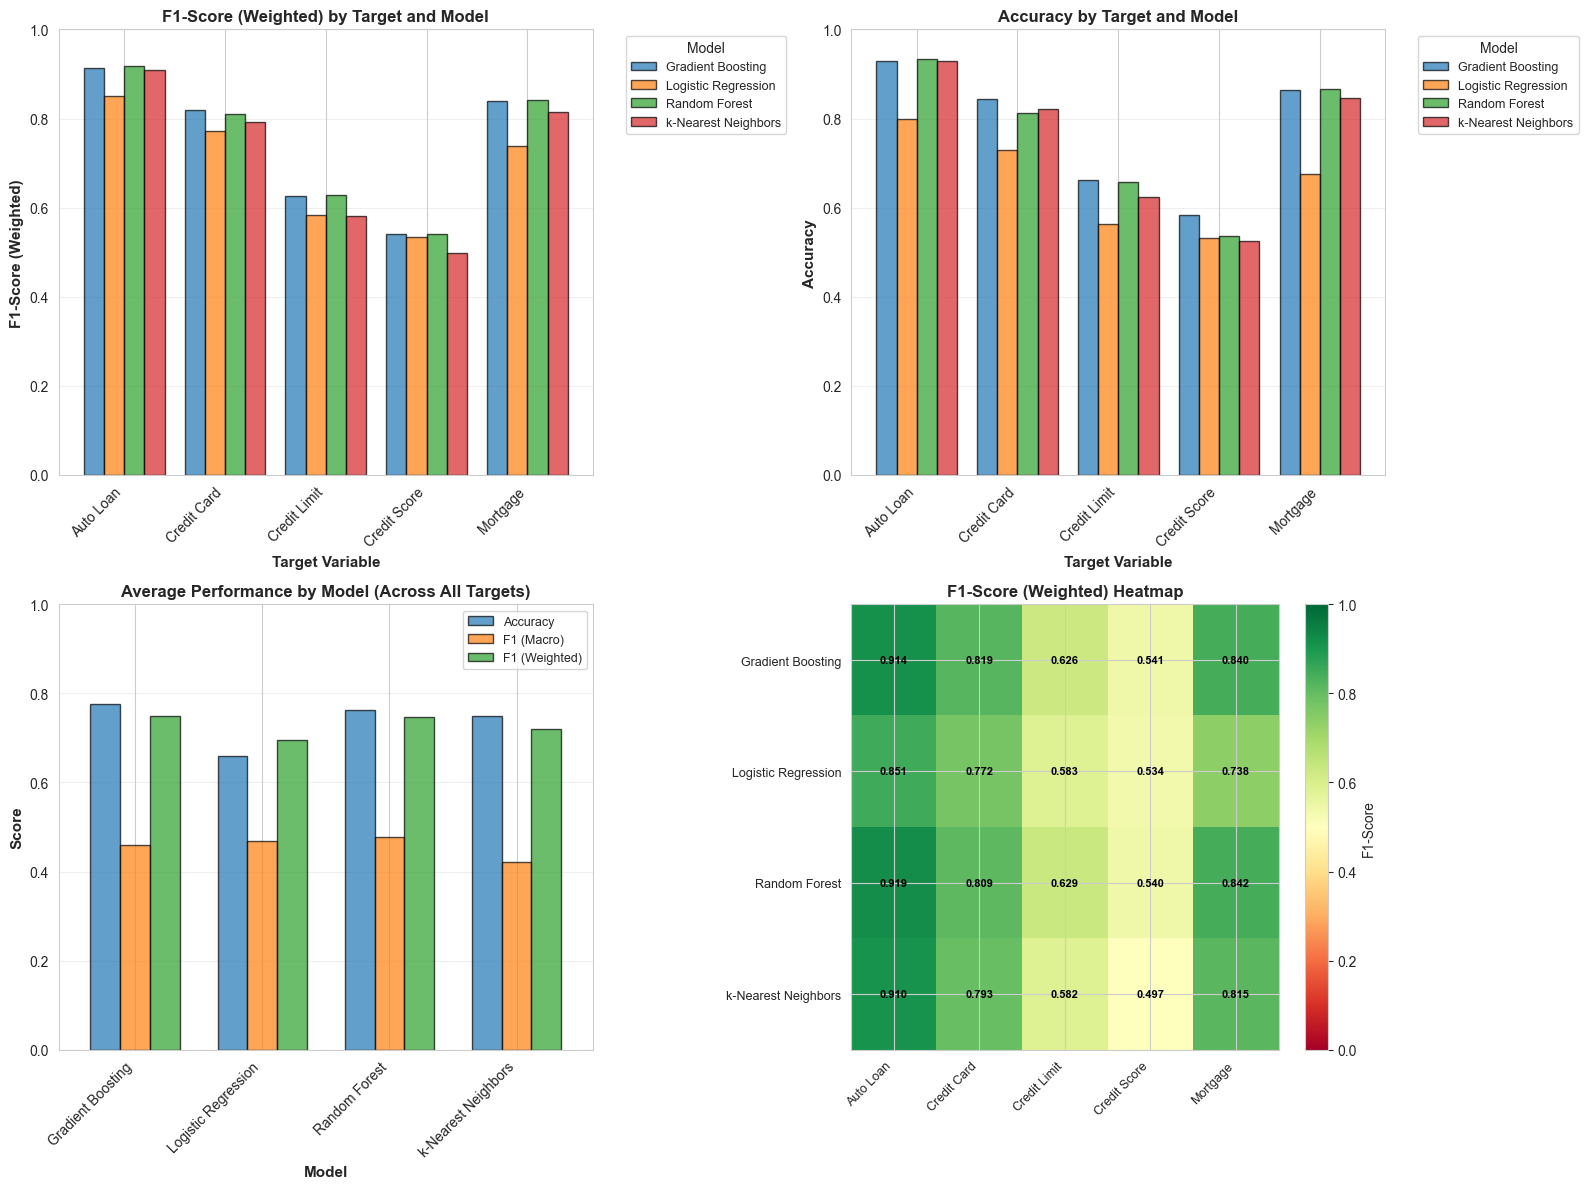


✓ Visualization complete


In [30]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Score comparison across all targets and models
ax = axes[0, 0]
pivot_f1 = results_df.pivot_table(
    index='Target',
    columns='Model',
    values='F1 (Weighted)',
    aggfunc='first'
)
pivot_f1.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.7)
ax.set_title('F1-Score (Weighted) by Target and Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Target Variable', fontsize=11, fontweight='bold')
ax.set_ylabel('F1-Score (Weighted)', fontsize=11, fontweight='bold')
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim([0, 1])

# 2. Accuracy comparison
ax = axes[0, 1]
pivot_acc = results_df.pivot_table(
    index='Target',
    columns='Model',
    values='Accuracy',
    aggfunc='first'
)
pivot_acc.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.7)
ax.set_title('Accuracy by Target and Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Target Variable', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim([0, 1])

# 3. Average performance by model
ax = axes[1, 0]
model_avg = results_df.groupby('Model')[['Accuracy', 'F1 (Macro)', 'F1 (Weighted)']].mean()
model_avg.plot(kind='bar', ax=ax, width=0.7, edgecolor='black', alpha=0.7)
ax.set_title('Average Performance by Model (Across All Targets)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.legend(['Accuracy', 'F1 (Macro)', 'F1 (Weighted)'], fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim([0, 1])

# 4. Performance heatmap
ax = axes[1, 1]
heatmap_data = results_df.pivot_table(
    index='Model',
    columns='Target',
    values='F1 (Weighted)',
    aggfunc='first'
)
im = ax.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(heatmap_data.index, fontsize=9)
ax.set_title('F1-Score (Weighted) Heatmap', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('F1-Score', fontsize=10)

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.values[i, j]
        if pd.notna(value):
            text = ax.text(j, i, f'{value:.3f}',
                          ha="center", va="center", color="black", fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")


### Method: Performance Comparison
  - Aggregate results from the Standard (All Features) and VIF (Selected Features) runs.
  - Calculate the net change in F1-Weighted score to quantify the impact of feature selection.
  - Present a side-by-side comparison table to identify cases where dimensionality reduction improved or degraded performance.


In [31]:
# Compare Original vs VIF
print("\n" + "="*80)
print("IMPACT OF FEATURE SELECTION (VIF)")
print("="*80)

comparison = pd.concat([results_original, results_vif])
pivot_comp = comparison.pivot_table(
    index=['Target', 'Model'], 
    columns='Run', 
    values='F1 (Weighted)'
)
pivot_comp['Diff'] = pivot_comp['VIF Selected Features'] - pivot_comp['Original Features']

print("F1 Weighted Score Comparison:")
print(pivot_comp.sort_values('Diff', ascending=False).to_string(float_format="{:.4f}".format))

avg_diff = pivot_comp['Diff'].mean()
print("-" * 80)
print(f"Average Performance Change: {avg_diff:+.4f}")
print("="*80)



IMPACT OF FEATURE SELECTION (VIF)
F1 Weighted Score Comparison:
Run                               Original Features  VIF Selected Features    Diff
Target       Model                                                                
Mortgage     Random Forest                   0.8419                 0.8537  0.0118
Auto Loan    Gradient Boosting               0.9140                 0.9179  0.0039
             Logistic Regression             0.8514                 0.8528  0.0015
Mortgage     k-Nearest Neighbors             0.8147                 0.8157  0.0011
Credit Card  k-Nearest Neighbors             0.7933                 0.7939  0.0006
Credit Score k-Nearest Neighbors             0.4975                 0.4979  0.0004
             Random Forest                   0.5398                 0.5398  0.0000
Auto Loan    Random Forest                   0.9187                 0.9186 -0.0000
Credit Card  Logistic Regression             0.7717                 0.7711 -0.0006
Credit Score Logistic 

### Method: Hyperparameter Optimization (Optuna)
  - Implement Bayesian optimization using Optuna to tune Random Forest and XGBoost models.
  - Define search spaces for critical hyperparameters (e.g., n_estimators, max_depth, learning_rate).
  - Allocate a specific time budget to optimize performance on key targets (Credit Card Outcome and Credit Score).
  - Select the best hyperparameter configuration based on 3-fold cross-validated F1-Weighted scores.


In [32]:
# Optuna Hyperparameter Tuning
print("="*80)
print("OPTUNA HYPERPARAMETER TUNING (RF & XGB)")
print("Time Limit: 10 minutes total")
print("="*80)

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_rf(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    }
    clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    score = cross_val_score(clf, X, y, cv=3, scoring='f1_weighted').mean()
    return score

def objective_xgb(trial, X, y):
    # Remap class labels if needed for XGB (must be 0 to N-1)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }
    
    clf = xgb.XGBClassifier(random_state=42, n_jobs=-1, **params)
    score = cross_val_score(clf, X, y_enc, cv=3, scoring='f1_weighted').mean()
    return score

# Tune on top targets (prioritize credit card & score)
tuning_targets = ['Credit Card', 'Credit Score']
tuned_metrics = []
start_time = time.time()
time_limit = 600 # 10 minutes

for target_name in tuning_targets:
    if target_name not in train_test_splits: continue
    
    print(f"\nTuning for: {target_name}")
    data = train_test_splits[target_name] # Use original features for tuning capacity
    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    
    # Check time budget
    elapsed = time.time() - start_time
    if elapsed > time_limit:
        print("Time limit reached. Stopping tuning.")
        break
    
    remaining_time = time_limit - elapsed
    target_budget = remaining_time / (len(tuning_targets) - tuning_targets.index(target_name))
    model_budget = target_budget / 2 # Split between RF and XGB
    
    # 1. Random Forest Tuning
    print(f"  RF Optimization ({int(model_budget)}s)...", end=" ")
    try:
        study_rf = optuna.create_study(direction='maximize')
        study_rf.optimize(lambda t: objective_rf(t, X_train, y_train), timeout=model_budget)
        
        rf_best = RandomForestClassifier(random_state=42, **study_rf.best_params)
        rf_best.fit(X_train, y_train)
        y_pred = rf_best.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        tuned_metrics.append({'Run': 'Optuna Tuned', 'Target': target_name, 'Model': 'Random Forest', 'F1 (Weighted)': f1, 'Accuracy': accuracy_score(y_test, y_pred), 'F1 (Macro)': f1_score(y_test, y_pred, average='macro', zero_division=0), 'N_Features': X_train.shape[1]})
        print(f"Best F1: {f1:.4f}")
    except Exception as e:
        print(f"RF Error: {e}")

    # 2. XGBoost Tuning
    print(f"  XGB Optimization ({int(model_budget)}s)...", end=" ")
    try:
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)
        
        study_xgb = optuna.create_study(direction='maximize')
        study_xgb.optimize(lambda t: objective_xgb(t, X_train, y_train), timeout=model_budget)
        
        xgb_best = xgb.XGBClassifier(random_state=42, **study_xgb.best_params)
        xgb_best.fit(X_train, y_train_enc)
        y_pred = xgb_best.predict(X_test)
        f1 = f1_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        tuned_metrics.append({'Run': 'Optuna Tuned', 'Target': target_name, 'Model': 'XGBoost', 'F1 (Weighted)': f1, 'Accuracy': accuracy_score(y_test_enc, y_pred), 'F1 (Macro)': f1_score(y_test_enc, y_pred, average='macro', zero_division=0), 'N_Features': X_train.shape[1]})
        print(f"Best F1: {f1:.4f}")
    except Exception as e:
        print(f"XGB Error: {e}")

print("="*80)


OPTUNA HYPERPARAMETER TUNING (RF & XGB)
Time Limit: 10 minutes total

Tuning for: Credit Card
  RF Optimization (149s)... Best F1: 0.8192
  XGB Optimization (149s)... Best F1: 0.8159

Tuning for: Credit Score
  RF Optimization (147s)... Best F1: 0.5549
  XGB Optimization (147s)... Best F1: 0.5493


FINAL MODEL COMPARISON (STANDARD vs VIF vs OPTUNA)


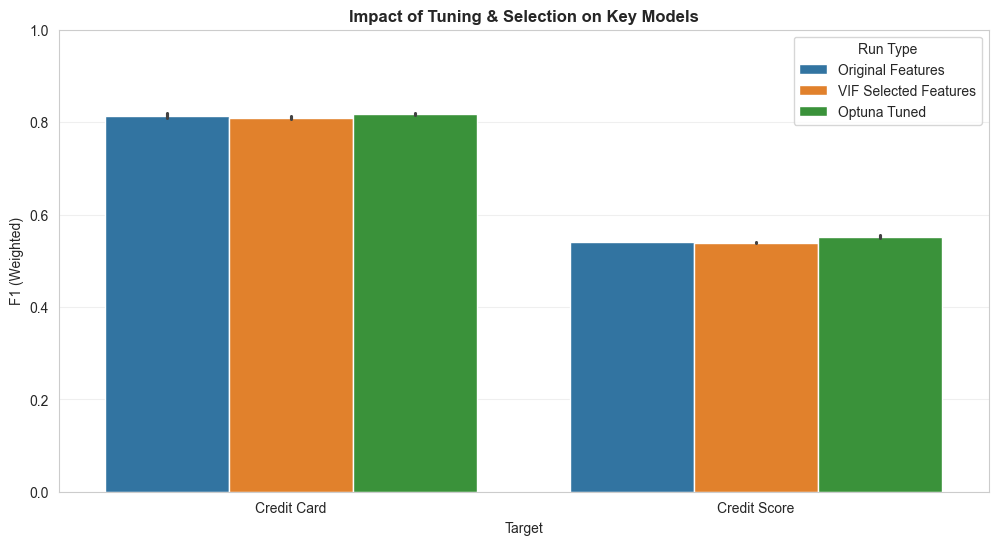


Final F1 (Weighted) Comparison:
Run                               Optuna Tuned  Original Features  VIF Selected Features
Target       Model                                                                      
Auto Loan    Gradient Boosting             NaN             0.9140                 0.9179
             Logistic Regression           NaN             0.8514                 0.8528
             Random Forest                 NaN             0.9187                 0.9186
             k-Nearest Neighbors           NaN             0.9100                 0.9090
Credit Card  Gradient Boosting             NaN             0.8188                 0.8130
             Logistic Regression           NaN             0.7717                 0.7711
             Random Forest              0.8192             0.8093                 0.8065
             XGBoost                    0.8159                NaN                    NaN
             k-Nearest Neighbors           NaN             0.7933            

In [33]:
# Final Comparison & Visualization
print("="*80)
print("FINAL MODEL COMPARISON (STANDARD vs VIF vs OPTUNA)")
print("="*80)

results_tuned = pd.DataFrame(tuned_metrics)
final_results = pd.concat([results_original, results_vif, results_tuned], ignore_index=True)

# Visualize F1 Weighted for Tuned Targets
tuned_targets = final_results[final_results['Run'] == 'Optuna Tuned']['Target'].unique()
if len(tuned_targets) > 0:
    plt.figure(figsize=(12, 6))
    subset = final_results[final_results['Target'].isin(tuned_targets) & 
                           final_results['Model'].isin(['Random Forest', 'XGBoost', 'Gradient Boosting'])]
    
    sns.barplot(data=subset, x='Target', y='F1 (Weighted)', hue='Run')
    plt.title('Impact of Tuning & Selection on Key Models', fontsize=12, fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Run Type')
    plt.show()

# Summary Table
pivot_final = final_results.pivot_table(
    index=['Target', 'Model'], 
    columns='Run', 
    values='F1 (Weighted)'
)
print("\nFinal F1 (Weighted) Comparison:")
print(pivot_final.to_string(float_format="{:.4f}".format))
print("="*80)


---
## 5. Feature Importance Analysis

Identify the most important predictors for each target variable using tree-based models


In [34]:
# Extract feature importance from tree-based models
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Models that have feature_importances_
tree_based_models = ['Random Forest', 'Gradient Boosting']

# Store feature importance for all targets
all_feature_importance = {}

for target_name, models_dict in all_models.items():
    print(f"\n{'='*80}")
    print(f"TARGET: {target_name}")
    print(f"{'='*80}")
    
    for model_name in tree_based_models:
        if model_name in models_dict:
            model = models_dict[model_name]
            
            # Get feature names (same for all splits from this target)
            X_train = train_test_splits[target_name]['X_train']
            feature_names = X_train.columns
            
            # Extract importance
            importances = model.feature_importances_
            
            # Create DataFrame
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            # Store
            key = f"{target_name}_{model_name}"
            all_feature_importance[key] = importance_df
            
            # Display top 10
            print(f"\n  {model_name} - Top 10 Features:")
            print("-"*80)
            top_10 = importance_df.head(10)
            for idx, row in top_10.iterrows():
                print(f"    {row['Feature']:40s}: {row['Importance']:.6f}")

print(f"\n{'='*80}")
print(f"✓ Feature importance extracted for {len(all_feature_importance)} model-target combinations")
print(f"{'='*80}")


FEATURE IMPORTANCE ANALYSIS

TARGET: Credit Card

  Random Forest - Top 10 Features:
--------------------------------------------------------------------------------
    ApprovalProbCC                          : 0.100154
    ApprovalProbAuto                        : 0.081338
    NoNeed                                  : 0.050011
    ExpectedDenial                          : 0.049840
    MaxedOutCC                              : 0.045933
    Obtain2000Prob                          : 0.044916
    RatesTooHigh                            : 0.038033
    DontKnowHow                             : 0.035641
    TooTimeConsuming                        : 0.032140
    MortgageBalance                         : 0.031241

  Gradient Boosting - Top 10 Features:
--------------------------------------------------------------------------------
    ApprovalProbCC                          : 0.391876
    ExpectedDenial                          : 0.041147
    LowLikelihoodExpectedDenial             : 0.04097

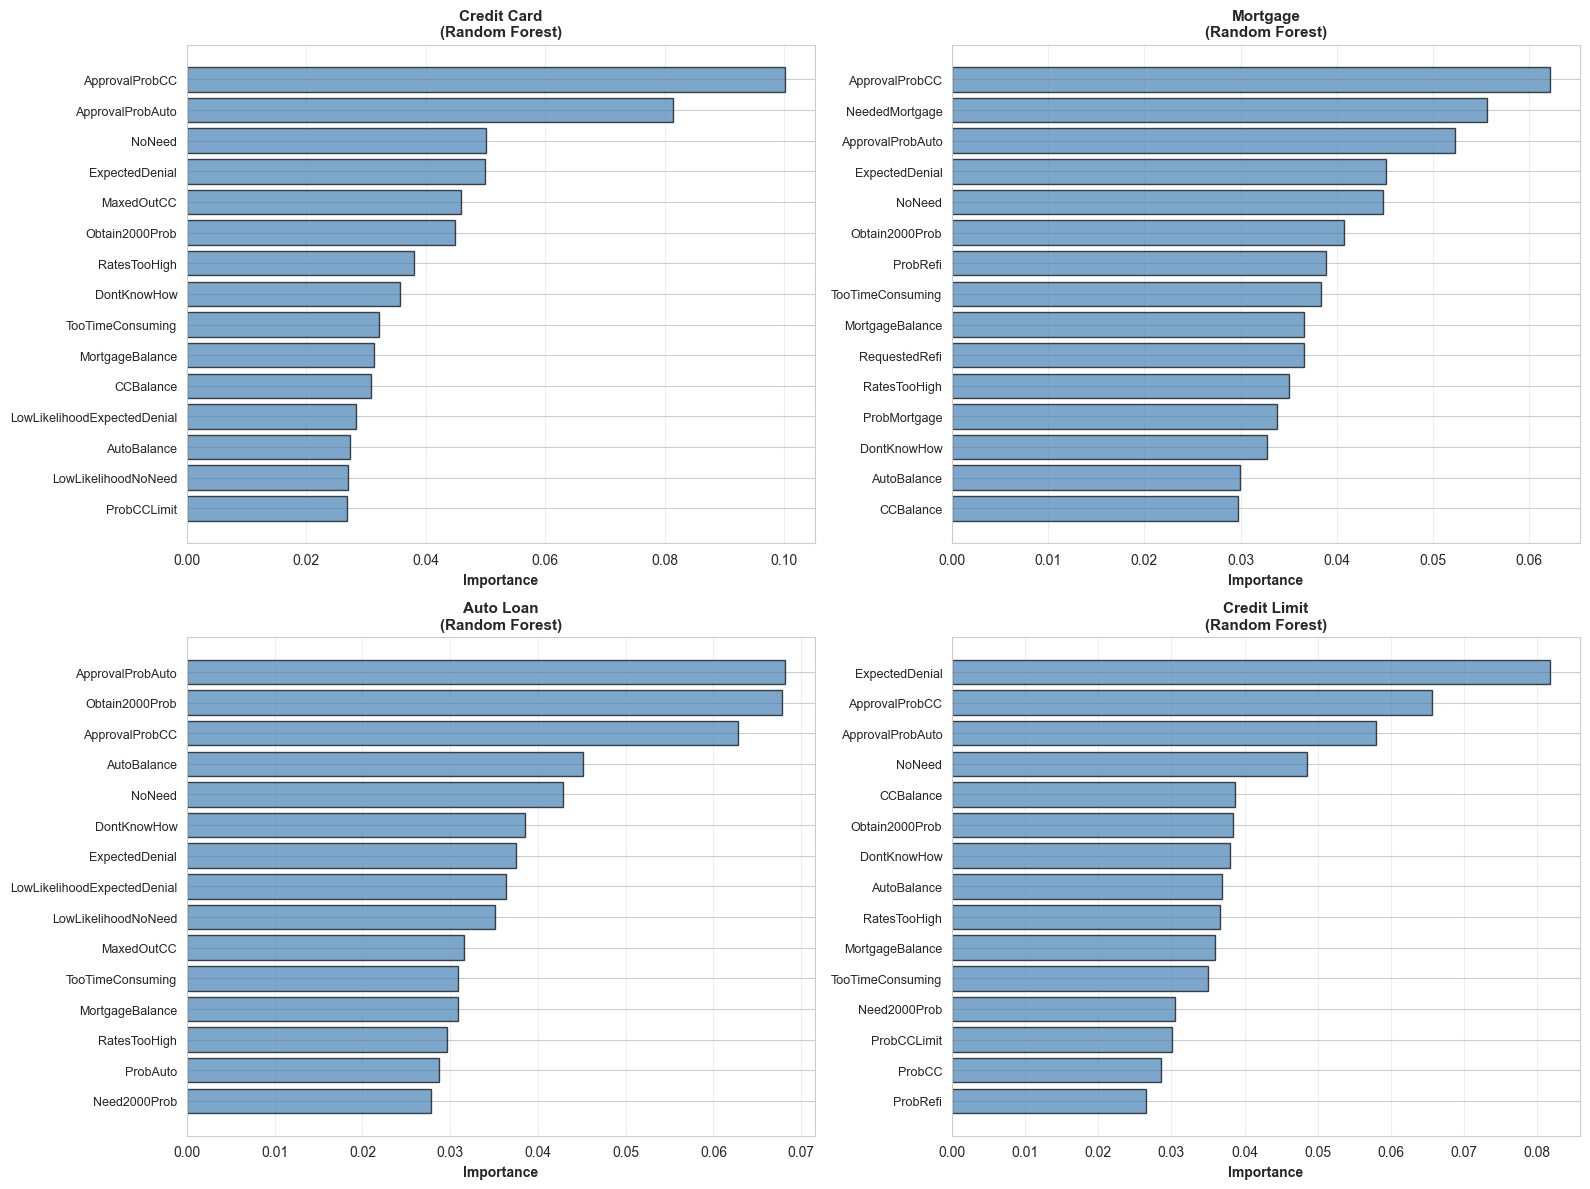


✓ Feature importance visualizations complete


In [35]:
# Visualize feature importance for key targets
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Select top targets to visualize
viz_targets = list(all_models.keys())[:4]  # First 4 targets

for idx, target_name in enumerate(viz_targets):
    ax = axes[idx]
    
    # Use Random Forest importance (if available)
    key = f"{target_name}_Random Forest"
    if key in all_feature_importance:
        importance_df = all_feature_importance[key]
        
        # Plot top 15 features
        top_features = importance_df.head(15)
        
        ax.barh(range(len(top_features)), top_features['Importance'].values, 
                color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['Feature'].values, fontsize=9)
        ax.set_xlabel('Importance', fontsize=10, fontweight='bold')
        ax.set_title(f'{target_name}\n(Random Forest)', fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance visualizations complete")


---
## 6. Save Results & Key Findings


### Method: Export & Insights
  - Serialize the final consolidated results and feature importance rankings to CSV files.
  - Use overwrite mode to ensure output files reflect the most recent execution.
  - Programmatically generate text-based insights summarizing the most predictable targets and best-performing algorithms.


In [36]:
# Save results to CSV files (Overwrite)
print("="*80)
print("SAVING RESULTS")
print("="*80)

# Save complete results table (Overwrite)
final_results.to_csv('model_results_final.csv', index=False, mode='w')
print(f"\nSaved final results to: model_results_final.csv (Overwritten)")

# Save feature importance for each target (Standard Run)
for key, importance_df in all_feature_importance.items():
    filename = f"feature_importance_{key.replace(' ', '_').replace('/', '_')}.csv"
    importance_df.to_csv(filename, index=False, mode='w')
    print(f"Saved {key} feature importance to: {filename}")

print("\n" + "="*80)
print("KEY FINDINGS & INSIGHTS")
print("="*80)

# Generate key findings
print("\n1. MODEL PERFORMANCE OVERVIEW:")
print("-" * 80)

best_target_performance = final_results.groupby('Target')['F1 (Weighted)'].mean().sort_values(ascending=False)
print(f"\n   Most predictable target: {best_target_performance.index[0]}")
print(f"     Average F1-Score: {best_target_performance.values[0]:.4f}")

best_overall_model = final_results.groupby('Model')['F1 (Weighted)'].mean().sort_values(ascending=False)
print(f"\n   Best overall model: {best_overall_model.index[0]}")
print(f"     Average F1-Score: {best_overall_model.values[0]:.4f}")

print("\n\n2. TARGET-SPECIFIC INSIGHTS:")
print("-" * 80)

for target in final_results['Target'].unique():
    target_data = final_results[final_results['Target'] == target].sort_values('F1 (Weighted)', ascending=False)
    if len(target_data) > 0:
        best_model = target_data.iloc[0]
        print(f"\n   {target}:")
        print(f"     Best Model: {best_model['Model']} ({best_model['Run']})")
        print(f"     Accuracy: {best_model['Accuracy']:.4f}")
        print(f"     F1-Score (Weighted): {best_model['F1 (Weighted)']:.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


SAVING RESULTS

Saved final results to: model_results_final.csv (Overwritten)
Saved Credit Card_Random Forest feature importance to: feature_importance_Credit_Card_Random_Forest.csv
Saved Credit Card_Gradient Boosting feature importance to: feature_importance_Credit_Card_Gradient_Boosting.csv
Saved Mortgage_Random Forest feature importance to: feature_importance_Mortgage_Random_Forest.csv
Saved Mortgage_Gradient Boosting feature importance to: feature_importance_Mortgage_Gradient_Boosting.csv
Saved Auto Loan_Random Forest feature importance to: feature_importance_Auto_Loan_Random_Forest.csv
Saved Auto Loan_Gradient Boosting feature importance to: feature_importance_Auto_Loan_Gradient_Boosting.csv
Saved Credit Limit_Random Forest feature importance to: feature_importance_Credit_Limit_Random_Forest.csv
Saved Credit Limit_Gradient Boosting feature importance to: feature_importance_Credit_Limit_Gradient_Boosting.csv
Saved Credit Score_Random Forest feature importance to: feature_importance